# STarter code

Load GDrive for data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Importing required libraries

In [2]:
# Asssign a randomness seed for our models

SEED = 20

# Importing basic libraries
from zipfile import ZipFile
import os, sys
import gc
import time
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json 
from string import punctuation
import pickle as pkl

%matplotlib inline

# Import NLTK
import nltk
nltk.download('punkt')
nltk.download('stopwords')

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

# Preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler

from sklearn.decomposition import PCA
from sklearn.metrics import f1_score

from wordcloud import WordCloud
# Import models

import lightgbm as lgb
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB

# Model selection
from sklearn.model_selection import RandomizedSearchCV

# Others

from tqdm import tqdm_notebook #Loads progressbars for various loops

from typing import List
import warnings

warnings.filterwarnings('ignore')

#####################
#Useful pandas settings

pd.set_option('display.max_rows', 400)
pd.set_option('display.max_columns', 160)
pd.set_option('display.max_colwidth', 40)
warnings.filterwarnings("ignore")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Some useful custom functions

In [3]:
################################################################################################

# Downcasting function for pandas dataframes

def downcast_dtypes(df):
  '''
      Changes column types in the dataframe:             
          `float64` type to lowest possible float without data loss
          `int64`   type to lowest possible int wihtout data loss
  '''
  
  # Select columns to downcast
  float_cols = [col for col in df if df[col].dtype == "float64"]
  int_cols =   [col for col in df if df[col].dtype == "int64"]
  
  # Downcast columns using to numeric function
  df[float_cols] = df[float_cols].apply(pd.to_numeric, downcast='float')
  df[int_cols] = df[int_cols].apply(pd.to_numeric, downcast='integer')

  # remove variables from memory to avoid issues
  
  del float_cols
  del int_cols
  
  return df

################################################################################################
# Check duplication at given level of dataframe

def check_dups(df, cols):

  orig_count_rows = df.shape[0]

  temp = df.groupby(cols).size().reset_index(name = 'counts')

  dedup_count_rows = temp.shape[0]

  if orig_count_rows == dedup_count_rows:
    print("No duplicates. Dataframe is unique at given level")
    print("# of unique entries: n=",orig_count_rows)
  else:
    print("Duplicates found. Dataframe is not unique at given level")
    print("# of entries in original dataset: n=", orig_count_rows)
    print("# of unique entries expected in deduped dataset: n=", dedup_count_rows)
    print("# of addational entries: n=", orig_count_rows - dedup_count_rows)

  del orig_count_rows, temp, dedup_count_rows

#####################################################################################
# Plotting classification features
def fancy_plot(df):
  column_names = list(df.columns.values)
  frauds = df[df['Class'] == 1]
  no_frauds = df[df['Class'] == 0]

  plt.figure()
  fig, ax = plt.subplots(8,4,figsize=(16,28))
  i = 0
  for feature in column_names:
      i += 1
      plt.subplot(8,4,i)
      sns.kdeplot(frauds[feature])
      sns.kdeplot(no_frauds[feature])
      plt.xlabel(feature, fontsize=10)
      locs, labels = plt.xticks()
      plt.tick_params(axis='both', which='major', labelsize=12)
  plt.show();

####################################################################################

########################################
#Custom function to apply functions to dataframe with missing values

def apply_func_to_df(df, func, target_col, new_col_name):
  df.loc[~df[target_col].isnull(),new_col_name] = df.loc[~df[target_col].isnull(),target_col].apply(func)


####################################################################################
#text cleaning and stemming function. Modified to cater to text provided

def clean_text(raw,return_type = 'token'):

  tokens = nltk.word_tokenize(raw)

  
  alph_num_tokens = [word for word in tokens if word.isalnum()]
  non_alph_num_tokens = [word for word in tokens if not word.isalnum()]
  
  non_alph_num_tokens = [word.split('-') for word in non_alph_num_tokens]
  non_alph_num_tokens = nltk.flatten(non_alph_num_tokens)
  non_alph_num_tokens = [word.split('.') for word in non_alph_num_tokens]
  non_alph_num_tokens = nltk.flatten(non_alph_num_tokens)

  alph_num_tokens.extend(non_alph_num_tokens)
  
  tokens = nltk.flatten(alph_num_tokens)

  tokens = [porter.stem(word.lower()) for word in tokens]
  tokens = [word for word in tokens if word not in stopwords_en]
  tokens = [word for word in tokens if word.isalnum()]

  return tokens

#####################################################
# Generate word clouds

def generate_wordclouds(X, in_X_tfidf, k, in_word_positions):
  # compute the total tfidf for each term in the cluster
  in_tfidf = in_X_tfidf[in_y_pred == in_cluster_id]
  # numpy.matrix
  tfidf_sum = np.sum(in_tfidf, axis=0)
  # numpy.array of shape (1, X.shape[1])
  tfidf_sum = np.asarray(tfidf_sum).reshape(-1)
  top_indices = tfidf_sum.argsort()[-top_count:]
  term_weights = {in_word_positions[in_idx]: tfidf_sum[in_idx] for in_idx in top_indices}
  wc = WordCloud(width=1200, height=800, background_color="white")
  wordcloud = wc.generate_from_frequencies(term_weights)
  fig, ax = plt.subplots(figsize=(10, 6), dpi=100)
  ax.imshow(wordcloud, interpolation='bilinear')
  ax.axis("off")
  fig.suptitle(f"Cluster {in_cluster_id}")
  plt.show()



In [4]:

base_path = '/content/drive/MyDrive/#Data Science/2021 ZS Hackathon/data/'

extracted_data_path = '/content/dataset/'
train_path = extracted_data_path + "train/"
test_path = extracted_data_path + "test/"

train_prod_info_path = train_path + 'product_info/'
test_prod_info_path = test_path + 'product_info/'

save_path = base_path + 'processed/'

# Checkpoint 0

1. Import datasets
2. Cleanup (deduplication, joining similar datasets, etc.)
3. EDA on individual datasets (sales, discount and footfall)
4. Save cleaned datasets as feather file and restart kernel

### Extract zip file in working dir

Extract data and start importingcsv files for each industry

In [ ]:
zip_location = base_path + "dataset.zip"

with ZipFile(zip_location, 'r') as zip:
    # extracting all the files
    zip.extractall()
    print('Done!')

Done!


In [ ]:
train_path = extracted_data_path + "train/"

### Import the base CSV files

In [ ]:
automobile_industry = pd.read_csv(train_path + 'automobile_industry.csv', parse_dates=['Start_date'])
computer_industry = pd.read_csv(train_path + 'computer_industry.csv', parse_dates=['Start_date'])
health_industry = pd.read_csv(train_path + 'health_industry.csv', parse_dates=['Start_date'])
manufacturing_industry = pd.read_csv(train_path + 'manufacturing_industry.csv', parse_dates=['Start_date'])
power_industry = pd.read_csv(train_path + 'power_industry.csv', parse_dates=['Start_date'])

test_data = pd.read_csv(test_path + 'test.csv', parse_dates=['Start_date'])

## Create masterlist of csv with industry as column

In [ ]:
automobile_industry['industry'] = 'Automobile Industry'
computer_industry['industry'] = 'Computer Industry'
health_industry['industry'] = 'Health Industry'
manufacturing_industry['industry'] = 'Manufacturing Industry'
power_industry['industry'] = 'Power Industry'

product_master_list = automobile_industry.append([computer_industry, health_industry, manufacturing_industry, power_industry],ignore_index=True)
product_master_list

,ID,Symbol,Start_date,market_cap,Sector,Country,CEO,No.of employee,Revenue (Cr),Net-valuation (Cr),Share_price (RS),Company_background,Type,Product,industry
0,PROJ0x5377,NaN,NaT,?,Private_sector,Guatemala,Pamela Terrano,NaN,15.226766068690289,2284.014910,325.200000,The LCV concept was created as a co...,Light Vehicles,Bike,Automobile Industry
1,PROJ0x24dc,NaN,NaT,small-cap,Private_sector,NaN,?,NaN,-999.0,-11230.811693,75.350000,Data movement is typically from one ...,Light Vehicles,AI,Automobile Industry
2,PROJ0x78e,NaN,NaT,large-cap,Public_sector,NaN,?,NaN,24.27911260914369,7283.733783,653.650000,1% share in Daimler AG.Dongfeng Moto...,Heavy Vehicles,JCP,Automobile Industry
3,PROJ0x403b,NaN,NaT,small-cap,Private_sector,NaN,?,17373.0,1.4027782279531942,35.069456,-22.246569,"Software patents, like other types o...",Light Vehicles,AI,Automobile Industry
4,PROJ0x8700,NaN,NaT,mid-cap,?,Madagascar,Elizabeth Finch,NaN,3.5152032346897326,703.040647,61.400000,Data transmission has three aspects:...,Light Vehicles,AI,Automobile Industry
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23904,PROJ0x7bb7,NaN,1960-04-01,?,?,NaN,Ivory Perry,NaN,13.213459723211047,NaN,309.700000,A switch to a circular economy woul...,green energy,Hydro,Power Industry
23905,PROJ0x70a7,NaN,NaT,large-cap,?,NaN,?,NaN,-999.0,NaN,-4718.551728,2 billion.By the middle of the 20th ...,green energy,Wind,Power Industry
23906,PROJ0x8488,NaN,NaT,?,Public_sector,NaN,?,NaN,12.891043524047364,NaN,-4423.263805,Leadership in Energy and Environment...,non green energy,charcoal,Power Industry
23907,PROJ0x613e,NaN,NaT,?,NaN,NaN,?,14514.0,2.180258593590086,218.025859,NaN,More sustainable sources of biomass ...,green energy,Wind,Power Industry


## Read product info files and parse them into stemmed token list

While parsing, I noticed that 1 txt file is been saved in different format. Upon inspecting with notepad and checking default locale, 'ANSI' format was applicable for the file. Further digging into it lead to file format being 'cp1252' (windows file format).

Update: Unable to import this file. Skip since its just 1 file. 

In [ ]:
file_id_list = os.listdir(train_prod_info_path)

product_info_corpus = []
product_id_list = []

error_counter = 0
error_files = []

for each_file in file_id_list:
  try:
    f = open(train_prod_info_path + each_file,'r')
    raw = f.read()
    product_info_corpus.append(raw)
    product_id_list.append(each_file[:-4])
  except:  
    error_counter += 1
    error_files.append(each_file)


In [ ]:
# 1 file has encoding error. We drop this file

for errors in error_files:
  file_id_list.remove(errors)

len(file_id_list)

23908

In [ ]:
product_desc_df = pd.DataFrame(data = product_id_list, columns = ['ID'])
product_desc_df['product_info'] = product_info_corpus

product_desc_df

,ID,product_info
0,PROJ0x33d9,The head is the energy per unit weig...
1,PROJ0x4ec9,75 lakh and INR 7.Australia has comp...
2,PROJ0x2caf,"In November 2009, Intel agreed to pa..."
3,PROJ0x126f,""" The European Academies' Science Ad..."
4,PROJ0x1b8c,Early deaths due to air pollution ha...
...,...,...
23903,PROJ0x558b,"More recently, the oldest-known wood..."
23904,PROJ0x5e60,Simple race games involve pure luck....
23905,PROJ0x1c95,"Lee, Newton (2015). Cybersecurity: A..."
23906,PROJ0x7ff2,In recent years its support has accr...


## Merge the product description with the masterlist to create a workable dataset

In [ ]:
masterdata = pd.merge(product_desc_df, product_master_list, how = 'left', on= ['ID'])
# Drop the entry with non readable product info
masterdata

,ID,product_info,Symbol,Start_date,market_cap,Sector,Country,CEO,No.of employee,Revenue (Cr),Net-valuation (Cr),Share_price (RS),Company_background,Type,Product,industry
0,PROJ0x33d9,The head is the energy per unit weig...,NaN,1996-08-01,?,?,NaN,Winifred Bilbro,NaN,10.485346633880084,-8615.138583,NaN,Biofuels are often produced from co...,green energy,Hydro,Power Industry
1,PROJ0x4ec9,75 lakh and INR 7.Australia has comp...,UST,1958-10-01,large-cap,Private_sector,NaN,Ruby Burnett,NaN,36.33430253875794,-10070.993139,-596.720031,"Power study, emerging markets accou...",Light Vehicles,Truck,Automobile Industry
2,PROJ0x2caf,"In November 2009, Intel agreed to pa...",EYG,1978-02-01,mid-cap,?,NaN,?,NaN,?,706.692488,-717.092361,Information services Information se...,Hardware,Gaming hardware,Computer Industry
3,PROJ0x126f,""" The European Academies' Science Ad...",MHRX,NaT,small-cap,?,NaN,?,NaN,4.892108834896404,489.210883,435.800000,The healthcare industry (also called...,Pharma,homeopathic,Health Industry
4,PROJ0x1b8c,Early deaths due to air pollution ha...,NaN,NaT,small-cap,?,Nepal,?,4869.0,-999.0,-26251.090822,341.200000,Other certificate systems that conf...,non green energy,charcoal,Power Industry
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23903,PROJ0x558b,"More recently, the oldest-known wood...",NaN,NaT,?,Public_sector,NaN,Mae Martini,NaN,22.856821291318393,5714.205323,1209.050000,(There is a push in some parts of t...,Software,IT,Computer Industry
23904,PROJ0x5e60,Simple race games involve pure luck....,NaN,1971-03-01,?,?,NaN,?,NaN,7.258065023329103,NaN,1637.203203,"Manufacturing, Engineering & Techno...",Mechanical,Kids toys,Manufacturing Industry
23905,PROJ0x1c95,"Lee, Newton (2015). Cybersecurity: A...",DES,NaT,large-cap,?,NaN,Patricia Perez,NaN,18.932698399084593,4733.174600,-2048.321428,"g.In an academic context, the Associ...",Security,antivirus-security,Computer Industry
23906,PROJ0x7ff2,In recent years its support has accr...,NaN,NaT,small-cap,NaN,NaN,?,NaN,2.494547168784917,NaN,133.500000,"Dongfeng Motor holds a 12.5% stake, ...",Heavy Vehicles,JCP,Automobile Industry


## Process test product information and create test dataset

In [ ]:
file_id_list = os.listdir(test_prod_info_path)

product_info_corpus = []
product_id_list = []

error_counter = 0
error_files = []

for each_file in file_id_list:
  try:
    f = open(test_prod_info_path + each_file,'r')
    raw = f.read()
    product_info_corpus.append(raw)
    product_id_list.append(each_file[:-4])
  except:  
    error_counter += 1
    error_files.append(each_file)

product_desc_df = pd.DataFrame(data = product_id_list, columns = ['ID'])
product_desc_df['product_info'] = product_info_corpus

test_data = pd.merge(test_data, product_desc_df, how = 'left', on= ['ID'])
# Drop the entry with non readable product info
test_data

,ID,Symbol,Start_date,market_cap,Sector,Country,CEO,No.of employee,Revenue (Cr),Net-valuation (Cr),Share_price (RS),Company_background,product_info
0,PROJ0x51fa,NaN,NaT,?,NaN,NaN,Vicenta Bronstein,NaN,0.6836318142997198,8507.104743,65.800000,The food processing industry is one ...,ISBN 978-0-9758252-0-4. ISBN 978-0-1...
1,PROJ0x3c88,NaN,NaT,large-cap,?,NaN,Nelson Bodkin,7964.0,?,NaN,1617.536129,Well-designed government policies th...,Wind energy penetration is the fract...
2,PROJ0x3e72,NaN,NaT,mid-cap,?,NaN,?,NaN,2.519536393657552,755.860918,755.400000,Information services Information se...,it is another good example of Artifi...
3,PROJ0x1129,NaN,1979-08-01,small-cap,NaN,NaN,?,NaN,-999.0,155.498484,94.700000,Not available,The following setup is configured in...
4,PROJ0x9029,NaN,NaT,small-cap,Private_sector,NaN,?,6954.0,?,34880.360760,NaN,"In 2007, there were about 806 millio...",New vehicles will be issued a virtua...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
15885,PROJ0x27fb,NaN,1993-03-01,?,NaN,NaN,?,NaN,55.683071526158216,16704.921458,639.500000,Some of the ethical issues associat...,"Today, parallel GPUs have begun maki..."
15886,PROJ0x3261,NaN,NaT,?,Private_sector,NaN,?,NaN,?,4472.540286,410.350000,Tata Motors and Marcopolo have a joi...,In-service examples are still in use...
15887,PROJ0x3aff,PTC,1993-10-01,large-cap,?,Croatia,Julia Witzke,26812.0,?,23137.331098,NaN,Since it is not possible to know wit...,"One use of the term ""computer securi..."
15888,PROJ0x1082,NaN,NaT,?,?,NaN,?,NaN,3.1675119878714577,-23193.286227,6173.390037,Cooking with polluting fuels causes ...,The price of wind power is therefore...


# Checkpoint 1

Identify hierarchy of the data and perfrorm preliminary checks



## Identify hierarchy and perfrom preliminary checks on targets

In [ ]:
temp = masterdata.groupby(['Type','Product','industry']).agg({'ID':'count'}).reset_index()
temp

,Type,Product,industry,ID
0,Diagnostic,Medical devices,Health Industry,757
1,Diagnostic,None,Health Industry,4
2,Diagnostic,allopathy,Health Industry,796
3,Food,Beverage,Manufacturing Industry,510
4,Food,Fastfood,Manufacturing Industry,566
5,Food,None,Manufacturing Industry,4
6,Food,Organicfood,Manufacturing Industry,480
7,Hardware,AI,Computer Industry,495
8,Hardware,Gaming hardware,Computer Industry,487
9,Hardware,Hardware accelerator,Computer Industry,456


###Check duplicates for each level to validate if we need to rename any class for consistency

- Automobile industry had one entry tagged as "Heavy vehicle". Has been renamed to "Heavy Vehicles" for consistency

-Computer industry needs investigation as same products are tagged under 2 parent classes (i.e. software and security). Will cause issues in model

In [ ]:
for industry in temp['industry'].unique():
  print("\nIndustry : "+ industry)
  for col in ['Type','Product']:
    print(col)
    print(np.sort(temp.loc[temp['industry'] == industry, col].unique()))


Industry : Health Industry
Type
['Diagnostic' 'Pharma']
Product
['Medical devices' 'None' 'Organicfood' 'allopathy' 'homeopathic' 'siddha']

Industry : Manufacturing Industry
Type
['Food' 'Mechanical' 'Production' 'Toys']
Product
['Beverage' 'Bike' 'Fastfood' 'Gaming hardware' 'Kids toys'
 'Medical devices' 'None' 'Organicfood' 'Wiring tools']

Industry : Computer Industry
Type
['Hardware' 'Security' 'Software']
Product
['AI' 'Cyber-security' 'Gaming hardware' 'Hardware accelerator' 'IT'
 'None' 'antivirus-security']

Industry : Automobile Industry
Type
['Heavy Vehicles' 'Heavy vehicle' 'Light Vehicles']
Product
['AI' 'Bike' 'Car' 'JCP' 'None' 'Truck']

Industry : Power Industry
Type
['green energy' 'non green energy']
Product
['Fuel' 'Hydro' 'None' 'Solar' 'Wind' 'charcoal']


In [ ]:
# Further check the Heavy vehicle entry to ensure its not mapped to different products

temp.loc[temp['Type'] == 'Heavy Vehicles',:]

,Type,Product,industry,ID
11,Heavy Vehicles,JCP,Automobile Industry,793
12,Heavy Vehicles,None,Automobile Industry,8
13,Heavy Vehicles,Truck,Automobile Industry,784


In [ ]:
temp.loc[temp['Type'] == 'Heavy vehicle',:]

,Type,Product,industry,ID
14,Heavy vehicle,Truck,Automobile Industry,1


COrrect the entry for Heavy vehicles to make it consistent

In [ ]:
masterdata.loc[masterdata['Type'] == 'Heavy vehicle','Type'] = 'Heavy Vehicles'

In [ ]:
# Check the computer industry and see if cyber security and antivirus are tagged under same class or different

temp.loc[temp['industry'] == 'Computer Industry',:]

,Type,Product,industry,ID
7,Hardware,AI,Computer Industry,495
8,Hardware,Gaming hardware,Computer Industry,487
9,Hardware,Hardware accelerator,Computer Industry,456
10,Hardware,None,Computer Industry,3
32,Security,Cyber-security,Computer Industry,457
33,Security,None,Computer Industry,2
34,Security,antivirus-security,Computer Industry,495
35,Software,AI,Computer Industry,501
36,Software,Cyber-security,Computer Industry,499
37,Software,Hardware accelerator,Computer Industry,469


In [ ]:
# Investigate if there is any key difference b/w Software and security type of products

masterdata.loc[masterdata['Type'] == 'Software', ['product_info','Company_background']].head()

,product_info,Company_background
20,The most common implementations of t...,Information technology (IT) is the u...
33,"A state of computer ""security"" is th...",Based on the storage and processing ...
35,Operative planning: A good security ...,A security referent is the focus of ...
40,Two attacks have been demonstrated t...,We shall call it information techno...
41,These tensor cores are also supposed...,"IMS stores data hierarchically, but..."


In [ ]:
masterdata.loc[masterdata['Type'] == 'Security', ['product_info','Company_background']].head()

,product_info,Company_background
7,Essentially all modern computer oper...,"They include, for example:Coercive ..."
98,"Lightpoint SecurityIn March 31, 2020...",".: security companies, security forc..."
100,Reverse engineering is the process b...,"They include, for example:Coercive ..."
123,"Surfacing in 2017, a new class of mu...",g.g.
132,They may have been added by an autho...,An early such system was IBM's Info...


In [ ]:
masterdata.columns.values

array(['ID', 'product_info', 'Symbol', 'Start_date', 'market_cap',
       'Sector', 'Country', 'CEO', 'No.of employee', 'Revenue (Cr)',
       'Net-valuation (Cr)', 'Share_price (RS)', 'Company_background',
       'Type', 'Product', 'industry'], dtype=object)

In [ ]:
masterdata.head()


,ID,product_info,Symbol,Start_date,market_cap,Sector,Country,CEO,No.of employee,Revenue (Cr),Net-valuation (Cr),Share_price (RS),Company_background,Type,Product,industry
0,PROJ0x33d9,The head is the energy per unit weig...,NaN,1996-08-01,?,?,NaN,Winifred Bilbro,NaN,10.485346633880084,-8615.138583,NaN,Biofuels are often produced from co...,green energy,Hydro,Power Industry
1,PROJ0x4ec9,75 lakh and INR 7.Australia has comp...,UST,1958-10-01,large-cap,Private_sector,NaN,Ruby Burnett,NaN,36.33430253875794,-10070.993139,-596.720031,"Power study, emerging markets accou...",Light Vehicles,Truck,Automobile Industry
2,PROJ0x2caf,"In November 2009, Intel agreed to pa...",EYG,1978-02-01,mid-cap,?,NaN,?,NaN,?,706.692488,-717.092361,Information services Information se...,Hardware,Gaming hardware,Computer Industry
3,PROJ0x126f,""" The European Academies' Science Ad...",MHRX,NaT,small-cap,?,NaN,?,NaN,4.892108834896404,489.210883,435.800000,The healthcare industry (also called...,Pharma,homeopathic,Health Industry
4,PROJ0x1b8c,Early deaths due to air pollution ha...,NaN,NaT,small-cap,?,Nepal,?,4869.0,-999.0,-26251.090822,341.200000,Other certificate systems that conf...,non green energy,charcoal,Power Industry


### Identify  and drop columns which lot of missing data

We will drop any column with >5% missing data

In [ ]:
#Training data
proportions = []
for col in masterdata.columns.values:
  entries = 23909
  proportions.append(masterdata[col].isnull().sum()*100/entries)

missing_table = pd.DataFrame(masterdata.columns.values, columns = ['Column name'])
missing_table['% missing'] = proportions
missing_table.sort_values(by = ['% missing'],ascending = False)

,Column name,% missing
6,Country,84.896901
2,Symbol,72.621189
3,Start_date,63.143586
8,No.of employee,59.994144
10,Net-valuation (Cr),33.514576
11,Share_price (RS),18.570413
5,Sector,12.238069
12,Company_background,0.351332
13,Type,0.313689
9,Revenue (Cr),0.192396


In [ ]:
# Test dataset
proportions = []
for col in test_data.columns.values:
  entries = 15890 
  proportions.append(test_data[col].isnull().sum()*100/entries)

missing_table = pd.DataFrame(test_data.columns.values, columns = ['Column name'])
missing_table['% missing'] = proportions
missing_table.sort_values(by = ['% missing'],ascending = False)

,Column name,% missing
5,Country,85.582127
1,Symbol,72.850850
2,Start_date,63.071114
7,No.of employee,60.459408
9,Net-valuation (Cr),32.511013
10,Share_price (RS),18.206419
4,Sector,12.448081
11,Company_background,0.308370
8,Revenue (Cr),0.195091
3,market_cap,0.144745


In [ ]:
drop_columns = missing_table.loc[missing_table['% missing'] >=5, ['Column name']]
drop_columns = drop_columns['Column name'].values.tolist()

masterdata = masterdata.drop(columns = drop_columns)
test_data = test_data.drop(columns = drop_columns)

print("Dropped columns : "+ ", ".join(drop_columns))

Dropped columns : Symbol, Start_date, Sector, Country, No.of employee, Net-valuation (Cr), Share_price (RS)


### Replace missing product/company info rows with blank string

In [ ]:
masterdata['Company_background'] = masterdata['Company_background'].fillna("")
masterdata['product_info'] = masterdata['product_info'].fillna("")

test_data['Company_background'] = test_data['Company_background'].fillna("")
test_data['product_info'] = test_data['product_info'].fillna("")

test_data

,ID,market_cap,CEO,Revenue (Cr),Company_background,product_info
0,PROJ0x51fa,?,Vicenta Bronstein,0.6836318142997198,The food processing industry is one ...,ISBN 978-0-9758252-0-4. ISBN 978-0-1...
1,PROJ0x3c88,large-cap,Nelson Bodkin,?,Well-designed government policies th...,Wind energy penetration is the fract...
2,PROJ0x3e72,mid-cap,?,2.519536393657552,Information services Information se...,it is another good example of Artifi...
3,PROJ0x1129,small-cap,?,-999.0,Not available,The following setup is configured in...
4,PROJ0x9029,small-cap,?,?,"In 2007, there were about 806 millio...",New vehicles will be issued a virtua...
...,...,...,...,...,...,...
15885,PROJ0x27fb,?,?,55.683071526158216,Some of the ethical issues associat...,"Today, parallel GPUs have begun maki..."
15886,PROJ0x3261,?,?,?,Tata Motors and Marcopolo have a joi...,In-service examples are still in use...
15887,PROJ0x3aff,large-cap,Julia Witzke,?,Since it is not possible to know wit...,"One use of the term ""computer securi..."
15888,PROJ0x1082,?,?,3.1675119878714577,Cooking with polluting fuels causes ...,The price of wind power is therefore...


In [ ]:
masterdata.info(null_counts = True)
test_data.info(null_counts = True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23908 entries, 0 to 23907
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   ID                  23908 non-null  object
 1   product_info        23908 non-null  object
 2   market_cap          23871 non-null  object
 3   CEO                 23881 non-null  object
 4   Revenue (Cr)        23862 non-null  object
 5   Company_background  23908 non-null  object
 6   Type                23833 non-null  object
 7   Product             23908 non-null  object
 8   industry            23908 non-null  object
dtypes: object(9)
memory usage: 1.8+ MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 15890 entries, 0 to 15889
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   ID                  15890 non-null  object
 1   market_cap          15867 non-null  object
 2   CEO                

### Few entries have product type missing

We will impute the missing ones by picking the most frequent type affilated to the said product-industry combination


In [ ]:
masterdata.loc[masterdata['Type'].isnull()]

temp = masterdata.groupby(['Product','industry','Type']).agg({'ID':'count'}).reset_index()
temp = temp.sort_values('ID', ascending = False)
temp = temp.groupby(['Product','industry']).agg({'Type':'first'}).reset_index()
temp.rename(columns={'Type':'impute_Type'}, inplace=True)
temp

# Map the type to masterdata and update the column if missing

masterdata = pd.merge(masterdata, temp, how = 'left',on = ['Product','industry'])
masterdata.loc[masterdata['Type'].isnull(),'Type'] = masterdata.loc[masterdata['Type'].isnull(),'impute_Type']
masterdata.drop(columns = ['impute_Type'], inplace = True)
masterdata

,ID,product_info,market_cap,CEO,Revenue (Cr),Company_background,Type,Product,industry
0,PROJ0x33d9,The head is the energy per unit weig...,?,Winifred Bilbro,10.485346633880084,Biofuels are often produced from co...,green energy,Hydro,Power Industry
1,PROJ0x4ec9,75 lakh and INR 7.Australia has comp...,large-cap,Ruby Burnett,36.33430253875794,"Power study, emerging markets accou...",Light Vehicles,Truck,Automobile Industry
2,PROJ0x2caf,"In November 2009, Intel agreed to pa...",mid-cap,?,?,Information services Information se...,Hardware,Gaming hardware,Computer Industry
3,PROJ0x126f,""" The European Academies' Science Ad...",small-cap,?,4.892108834896404,The healthcare industry (also called...,Pharma,homeopathic,Health Industry
4,PROJ0x1b8c,Early deaths due to air pollution ha...,small-cap,?,-999.0,Other certificate systems that conf...,non green energy,charcoal,Power Industry
...,...,...,...,...,...,...,...,...,...
23903,PROJ0x558b,"More recently, the oldest-known wood...",?,Mae Martini,22.856821291318393,(There is a push in some parts of t...,Software,IT,Computer Industry
23904,PROJ0x5e60,Simple race games involve pure luck....,?,?,7.258065023329103,"Manufacturing, Engineering & Techno...",Mechanical,Kids toys,Manufacturing Industry
23905,PROJ0x1c95,"Lee, Newton (2015). Cybersecurity: A...",large-cap,Patricia Perez,18.932698399084593,"g.In an academic context, the Associ...",Security,antivirus-security,Computer Industry
23906,PROJ0x7ff2,In recent years its support has accr...,small-cap,?,2.494547168784917,"Dongfeng Motor holds a 12.5% stake, ...",Heavy Vehicles,JCP,Automobile Industry


In [ ]:
masterdata.info(null_counts = True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23908 entries, 0 to 23907
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   ID                  23908 non-null  object
 1   product_info        23908 non-null  object
 2   market_cap          23871 non-null  object
 3   CEO                 23881 non-null  object
 4   Revenue (Cr)        23862 non-null  object
 5   Company_background  23908 non-null  object
 6   Type                23908 non-null  object
 7   Product             23908 non-null  object
 8   industry            23908 non-null  object
dtypes: object(9)
memory usage: 1.8+ MB


### Check revenue column

Missing values: Tagged as "?", NaN, -999

We replace the ? as NaN and convert column to float. We will add a flag for missing revenue

9439(40%) values are missing from train data. 6276(40%) values missing from test data

In [ ]:
temp = masterdata.copy()
temp.loc[:,['Revenue (Cr)']].sort_values(by = 'Revenue (Cr)')

,Revenue (Cr)
11954,-999.0
4334,-999.0
4333,-999.0
13659,-999.0
13662,-999.0
...,...
21376,NaN
21536,NaN
22055,NaN
23338,NaN


In [ ]:
masterdata.loc[masterdata['Revenue (Cr)'] == "?",'Revenue (Cr)'] = np.NaN
masterdata['Revenue (Cr)'] = masterdata['Revenue (Cr)'].astype('float')
masterdata['Revenue (Cr)'] = masterdata['Revenue (Cr)'].fillna(-999)

masterdata['missing_revenue'] = 0
masterdata.loc[masterdata['Revenue (Cr)'] < 0,'missing_revenue'] = 1

masterdata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23908 entries, 0 to 23907
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID                  23908 non-null  object 
 1   product_info        23908 non-null  object 
 2   market_cap          23871 non-null  object 
 3   CEO                 23881 non-null  object 
 4   Revenue (Cr)        23908 non-null  float64
 5   Company_background  23908 non-null  object 
 6   Type                23908 non-null  object 
 7   Product             23908 non-null  object 
 8   industry            23908 non-null  object 
 9   missing_revenue     23908 non-null  int64  
dtypes: float64(1), int64(1), object(8)
memory usage: 2.0+ MB


In [ ]:
test_data.info(null_counts = True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15890 entries, 0 to 15889
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   ID                  15890 non-null  object
 1   market_cap          15867 non-null  object
 2   CEO                 15870 non-null  object
 3   Revenue (Cr)        15859 non-null  object
 4   Company_background  15890 non-null  object
 5   product_info        15890 non-null  object
dtypes: object(6)
memory usage: 869.0+ KB


In [ ]:
# Replicate for test data. 
test_data.loc[test_data['Revenue (Cr)'] == "?",'Revenue (Cr)'] = np.NaN
test_data['Revenue (Cr)'] = test_data['Revenue (Cr)'].astype('float')
test_data['Revenue (Cr)'] = test_data['Revenue (Cr)'].fillna(-999)

test_data['missing_revenue'] = 0
test_data.loc[test_data['Revenue (Cr)'] < 0,'missing_revenue'] = 1

test_data.loc[test_data['Revenue (Cr)']<0,:].count()

ID                    6276
market_cap            6267
CEO                   6267
Revenue (Cr)          6276
Company_background    6276
product_info          6276
missing_revenue       6276
dtype: int64

In [ ]:
masterdata[['Revenue (Cr)']].sort_values(by = 'Revenue (Cr)')

masterdata.loc[masterdata['Revenue (Cr)'] <0,:].count()

masterdata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23908 entries, 0 to 23907
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID                  23908 non-null  object 
 1   product_info        23908 non-null  object 
 2   market_cap          23871 non-null  object 
 3   CEO                 23881 non-null  object 
 4   Revenue (Cr)        23908 non-null  float64
 5   Company_background  23908 non-null  object 
 6   Type                23908 non-null  object 
 7   Product             23908 non-null  object 
 8   industry            23908 non-null  object 
 9   missing_revenue     23908 non-null  int64  
dtypes: float64(1), int64(1), object(8)
memory usage: 2.0+ MB


### Check market cap

Missing values are filled with ? or nan

We will make it consistent and change it to N/A

12,091(~50%) values missing in train data. 7,996 (50%) values missing from test data

In [ ]:
masterdata['market_cap'].unique()

masterdata.loc[masterdata['market_cap'] == "?",'market_cap'] = "N/A"
masterdata.loc[masterdata['market_cap'].isnull(),'market_cap'] = "N/A"

#Add missing flag
masterdata['missing_market_cap'] = 0
masterdata.loc[masterdata['market_cap'] == "N/A",'missing_market_cap'] = 1

masterdata['market_cap'].unique()

array(['N/A', 'large-cap', 'mid-cap', 'small-cap'], dtype=object)

In [ ]:
masterdata.groupby(['market_cap']).agg({'ID':'count'})

,ID
market_cap,
N/A,12091
large-cap,5155
mid-cap,1867
small-cap,4795


In [ ]:
# Replicate for test dataset
test_data['market_cap'].unique()

test_data.loc[test_data['market_cap'] == "?",'market_cap'] = "N/A"
test_data.loc[test_data['market_cap'].isnull(),'market_cap'] = "N/A"

#Add missing flag
test_data['missing_market_cap'] = 0
test_data.loc[test_data['market_cap'] == "N/A",'missing_market_cap'] = 1

test_data['market_cap'].unique()

array(['N/A', 'large-cap', 'mid-cap', 'small-cap'], dtype=object)

In [ ]:
test_data.groupby(['market_cap']).agg({'ID':'count'})

,ID
market_cap,
N/A,7996
large-cap,3360
mid-cap,1286
small-cap,3248


### Check CEO

Missing tagged as "?" or null values. We wll impute this as N/A

In [ ]:
temp = masterdata.copy()

temp = temp.loc[:,['CEO']]

temp['CEO_length'] = temp['CEO'].apply(lambda x: len(str(x)))

temp.loc[temp['CEO_length']<=5,'CEO'].unique()

array(['?', nan], dtype=object)

In [ ]:
temp = test_data.copy()

temp = temp.loc[:,['CEO']]

temp['CEO_length'] = temp['CEO'].apply(lambda x: len(str(x)))

temp.loc[temp['CEO_length']<=5,'CEO'].unique()

array(['?', nan], dtype=object)

In [ ]:
# Train dataset

masterdata.loc[masterdata['CEO'] == "?",'CEO'] = "N/A"
masterdata.loc[masterdata['CEO'].isnull(),'CEO'] = "N/A"

# Test dataset

test_data.loc[test_data['CEO'] == "?",'CEO'] = "N/A"
test_data.loc[test_data['CEO'].isnull(),'CEO'] = "N/A"

# Add missing flag
masterdata['missing_CEO'] = 0
masterdata.loc[masterdata['CEO'] == "N/A",'missing_CEO'] = 1


test_data['missing_CEO'] = 0
test_data.loc[masterdata['CEO'] == "N/A",'missing_CEO'] = 1


In [ ]:
masterdata.columns.values

array(['ID', 'product_info', 'market_cap', 'CEO', 'Revenue (Cr)',
       'Company_background', 'Type', 'Product', 'industry',
       'missing_revenue', 'missing_market_cap', 'missing_CEO'],
      dtype=object)

In [ ]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15890 entries, 0 to 15889
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID                  15890 non-null  object 
 1   market_cap          15890 non-null  object 
 2   CEO                 15890 non-null  object 
 3   Revenue (Cr)        15890 non-null  float64
 4   Company_background  15890 non-null  object 
 5   product_info        15890 non-null  object 
 6   missing_revenue     15890 non-null  int64  
 7   missing_market_cap  15890 non-null  int64  
 8   missing_CEO         15890 non-null  int64  
dtypes: float64(1), int64(3), object(5)
memory usage: 1.2+ MB


## EDA General trends based on company information

We will investigate if there are any patterns based on market cap.

Observations: Most of the entries do not have a market cap specified. We can drop market cap from masterdata

### Market cap

Majority of entries do not have market cap available

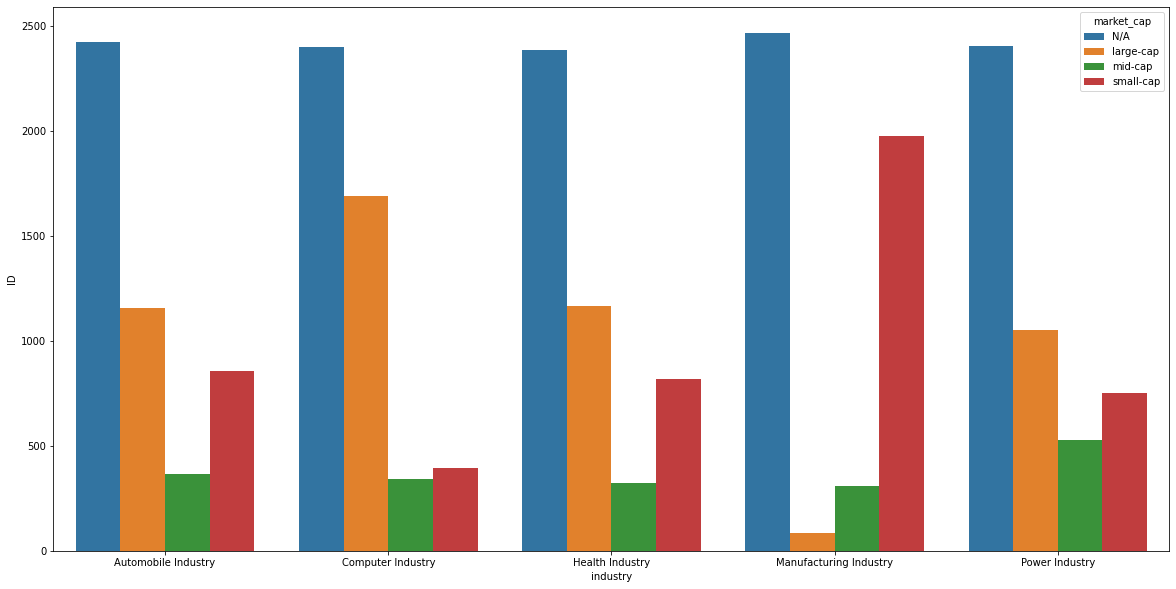

In [ ]:
temp = masterdata.groupby(['industry','market_cap']).agg({'ID':'count'}).reset_index()
plt.figure(figsize = (20,10))
sns.barplot(data = temp, x = 'industry',y = 'ID',hue = 'market_cap')

### Revenue

OF the 23,908 entries, 19520 have numeric revenue numbers.

Of the 19520, only 14469 have valid numeric values. This makes it so that significant chunk of data does not have revenue numbers available. 


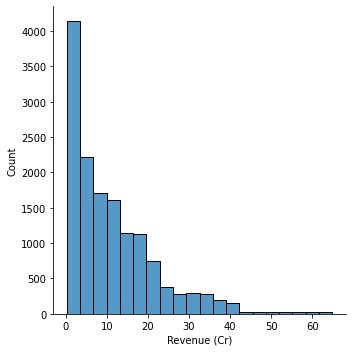

In [ ]:
sns.set(rc={'figure.figsize':(20,10)},font_scale=1.5)
sns.displot(ax = ax, data = masterdata.loc[masterdata['missing_revenue'] == 0,:], x = 'Revenue (Cr)', bins = 20, hue = 'industry',height = 10, aspect= 1)
plt.show()

In [ ]:
masterdata

,ID,product_info,market_cap,CEO,Revenue (Cr),Company_background,Type,Product,industry,missing_revenue,missing_market_cap,missing_CEO
0,PROJ0x33d9,The head is the energy per unit weig...,N/A,Winifred Bilbro,10.485347,Biofuels are often produced from co...,green energy,Hydro,Power Industry,0,1,0
1,PROJ0x4ec9,75 lakh and INR 7.Australia has comp...,large-cap,Ruby Burnett,36.334303,"Power study, emerging markets accou...",Light Vehicles,Truck,Automobile Industry,0,0,0
2,PROJ0x2caf,"In November 2009, Intel agreed to pa...",mid-cap,N/A,-999.000000,Information services Information se...,Hardware,Gaming hardware,Computer Industry,1,0,1
3,PROJ0x126f,""" The European Academies' Science Ad...",small-cap,N/A,4.892109,The healthcare industry (also called...,Pharma,homeopathic,Health Industry,0,0,1
4,PROJ0x1b8c,Early deaths due to air pollution ha...,small-cap,N/A,-999.000000,Other certificate systems that conf...,non green energy,charcoal,Power Industry,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
23903,PROJ0x558b,"More recently, the oldest-known wood...",N/A,Mae Martini,22.856821,(There is a push in some parts of t...,Software,IT,Computer Industry,0,1,0
23904,PROJ0x5e60,Simple race games involve pure luck....,N/A,N/A,7.258065,"Manufacturing, Engineering & Techno...",Mechanical,Kids toys,Manufacturing Industry,0,1,1
23905,PROJ0x1c95,"Lee, Newton (2015). Cybersecurity: A...",large-cap,Patricia Perez,18.932698,"g.In an academic context, the Associ...",Security,antivirus-security,Computer Industry,0,0,0
23906,PROJ0x7ff2,In recent years its support has accr...,small-cap,N/A,2.494547,"Dongfeng Motor holds a 12.5% stake, ...",Heavy Vehicles,JCP,Automobile Industry,0,0,1


### CEO check

Hoping CEO would be good indicatiors of industry type, we will check how many CEOs are common b/w train and test

However, 99% of train CEOs are not in test. So CEO wont contribute anything

In [ ]:
train_ceo = masterdata.loc[:,['CEO']]
train_ceo.drop_duplicates(inplace = True)
train_ceo['train_flag'] = 1

test_ceo = test_data.loc[:,['CEO']]
test_ceo.drop_duplicates(inplace = True)
test_ceo['test_flag'] = 1

temp = train_ceo.append(test_ceo)

temp = set(temp['CEO'])

all_ceo = pd.DataFrame(data = temp, columns = ["CEO"])

all_ceo = pd.merge(all_ceo, train_ceo, how = 'left', on = "CEO")
all_ceo = pd.merge(all_ceo, test_ceo, how = 'left', on = "CEO")
all_ceo = all_ceo.fillna(0)
all_ceo['total_flag'] = all_ceo['train_flag'] + all_ceo['test_flag']
all_ceo.groupby(['total_flag']).count()

,CEO,train_flag,test_flag
total_flag,,,
1.0,14201,14201,14201
2.0,107,107,107


In [ ]:
print("Unique train CEO:" + str(train_ceo.shape[0]))
print("Unique test CEO:" + str(test_ceo.shape[0]))

print("CEO in train not in test: "+str(np.setdiff1d(train_ceo['CEO'], test_ceo['CEO']).size))

Unique train CEO:8570
Unique test CEO:5845
CEO in train not in test: 8463


# Checkpoint 2

We will convert the text columns to features and run models

### Retain only important colummns 

In [ ]:
masterdata.columns.values

array(['ID', 'product_info', 'market_cap', 'CEO', 'Revenue (Cr)',
       'Company_background', 'Type', 'Product', 'industry',
       'missing_revenue', 'missing_market_cap', 'missing_CEO'],
      dtype=object)

In [ ]:
retain_cols = ['ID', 'product_info', 'market_cap', 'Revenue (Cr)',
       'Company_background', 'Type', 'Product', 'industry',
       'missing_revenue', 'missing_market_cap']

retain_cols_test = ['ID', 'product_info', 'market_cap', 'Revenue (Cr)',
       'Company_background', 'missing_revenue', 'missing_market_cap']

masterdata = masterdata.loc[:,retain_cols]
test_data = test_data.loc[:,retain_cols_test]

### Function for tokenize words

In [ ]:
# Define stemmer class
porter = PorterStemmer()

# Define stopwords
stopwords_en = set(stopwords.words('english'))

# Moved to top for consistency

### TOkenize company info

There are few missing values which we will ignore

In [ ]:
# Generate stemmed token list for the 2 columns
apply_func_to_df(masterdata, clean_text, 'Company_background','company_info_tokens')
apply_func_to_df(masterdata, clean_text, 'product_info','product_info_tokens')

# Generate string of tokenized stemmed words to make it easy to use later
apply_func_to_df(masterdata, lambda x: " ".join(x), 'company_info_tokens','company_info_tokens_string')

apply_func_to_df(masterdata, lambda x: " ".join(x), 'product_info_tokens','product_info_tokens_string')

# Generate a combined string to generate first set of predictions

masterdata['combined_string'] = masterdata['company_info_tokens_string'].str.cat(masterdata['product_info_tokens_string'], sep = " ")

masterdata

,ID,product_info,market_cap,Revenue (Cr),Company_background,Type,Product,industry,missing_revenue,missing_market_cap,company_info_tokens,product_info_tokens,company_info_tokens_string,product_info_tokens_string,combined_string
0,PROJ0x33d9,The head is the energy per unit weig...,N/A,10.485347,Biofuels are often produced from co...,green energy,Hydro,Power Industry,0,1,"[biofuel, often, produc, corn, sugar...","[head, energi, per, unit, weight, un...",biofuel often produc corn sugar cane...,head energi per unit weight unit mas...,biofuel often produc corn sugar cane...
1,PROJ0x4ec9,75 lakh and INR 7.Australia has comp...,large-cap,36.334303,"Power study, emerging markets accou...",Light Vehicles,Truck,Automobile Industry,0,0,"[power, studi, emerg, market, accoun...","[75, lakh, inr, ha, complex, regul, ...",power studi emerg market account 51 ...,75 lakh inr ha complex regul weight ...,power studi emerg market account 51 ...
2,PROJ0x2caf,"In November 2009, Intel agreed to pa...",mid-cap,-999.000000,Information services Information se...,Hardware,Gaming hardware,Computer Industry,1,0,"[inform, servic, inform, servic, ter...","[novemb, 2009, intel, agre, pay, amd...",inform servic inform servic term som...,novemb 2009 intel agre pay amd 1 amd...,inform servic inform servic term som...
3,PROJ0x126f,""" The European Academies' Science Ad...",small-cap,4.892109,The healthcare industry (also called...,Pharma,homeopathic,Health Industry,0,0,"[healthcar, industri, also, call, me...","[european, academi, scienc, advisori...",healthcar industri also call medic i...,european academi scienc advisori cou...,healthcar industri also call medic i...
4,PROJ0x1b8c,Early deaths due to air pollution ha...,small-cap,-999.000000,Other certificate systems that conf...,non green energy,charcoal,Power Industry,1,0,"[certif, system, confirm, sustain, b...","[earli, death, due, air, pollut, est...",certif system confirm sustain build ...,earli death due air pollut estim 200...,certif system confirm sustain build ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23903,PROJ0x558b,"More recently, the oldest-known wood...",N/A,22.856821,(There is a push in some parts of t...,Software,IT,Computer Industry,0,1,"[push, part, softwar, industri, merg...","[recent, wooden, wheel, world, wa, f...",push part softwar industri merg desk...,recent wooden wheel world wa found l...,push part softwar industri merg desk...
23904,PROJ0x5e60,Simple race games involve pure luck....,N/A,7.258065,"Manufacturing, Engineering & Techno...",Mechanical,Kids toys,Manufacturing Industry,0,1,"[manufactur, engin, technolog, much,...","[simpl, race, game, involv, pure, lu...",manufactur engin technolog much worl...,simpl race game involv pure luck cat...,manufactur engin technolog much worl...
23905,PROJ0x1c95,"Lee, Newton (2015). Cybersecurity: A...",large-cap,18.932698,"g.In an academic context, the Associ...",Security,antivirus-security,Computer Industry,0,0,"[academ, context, associ, comput, ma...","[lee, newton, 2015, cybersecur, gene...",academ context associ comput machine...,lee newton 2015 cybersecur gener ref...,academ context associ comput machine...
23906,PROJ0x7ff2,In recent years its support has accr...,small-cap,2.494547,"Dongfeng Motor holds a 12.5% stake, ...",Heavy Vehicles,JCP,Automobile Industry,0,0,"[dongfeng, motor, hold, stake, sheny...","[recent, year, support, ha, accru, 2...",dongfeng motor hold stake shenyang m...,recent year support ha accru 2014 ge...,dongfeng motor hold stake shenyang m...


In [ ]:
# Generate stemmed token list for the 2 columns
apply_func_to_df(test_data, clean_text, 'Company_background','company_info_tokens')
apply_func_to_df(test_data, clean_text, 'product_info','product_info_tokens')

# Generate string of tokenized stemmed words to make it easy to use later
apply_func_to_df(test_data, lambda x: " ".join(x), 'company_info_tokens','company_info_tokens_string')

apply_func_to_df(test_data, lambda x: " ".join(x), 'product_info_tokens','product_info_tokens_string')

# Generate a combined string to generate first set of predictions

test_data['combined_string'] = test_data['company_info_tokens_string'].str.cat(test_data['product_info_tokens_string'], sep = " ")

test_data

,ID,product_info,market_cap,Revenue (Cr),Company_background,missing_revenue,missing_market_cap,company_info_tokens,product_info_tokens,company_info_tokens_string,product_info_tokens_string,combined_string
0,PROJ0x51fa,ISBN 978-0-9758252-0-4. ISBN 978-0-1...,N/A,0.683632,The food processing industry is one ...,0,1,"[food, process, industri, one, large...","[isbn, isbn, fruit, develop, flower,...",food process industri one largest in...,isbn isbn fruit develop flower bioim...,food process industri one largest in...
1,PROJ0x3c88,Wind energy penetration is the fract...,large-cap,-999.000000,Well-designed government policies th...,1,0,"[govern, polici, promot, energi, sys...","[wind, energi, penetr, fraction, ene...",govern polici promot energi system t...,wind energi penetr fraction energi p...,govern polici promot energi system t...
2,PROJ0x3e72,it is another good example of Artifi...,mid-cap,2.519536,Information services Information se...,0,0,"[inform, servic, inform, servic, ter...","[anoth, good, exampl, artifici, inte...",inform servic inform servic term som...,anoth good exampl artifici intellig ...,inform servic inform servic term som...
3,PROJ0x1129,The following setup is configured in...,small-cap,-999.000000,Not available,1,0,[avail],"[follow, setup, configur, sensor, de...",avail,follow setup configur sensor detect ...,avail follow setup configur sensor d...
4,PROJ0x9029,New vehicles will be issued a virtua...,small-cap,-999.000000,"In 2007, there were about 806 millio...",1,0,"[2007, 806, million, car, light, tru...","[new, vehicl, issu, virtual, identif...",2007 806 million car light truck roa...,new vehicl issu virtual identif cons...,2007 806 million car light truck roa...
...,...,...,...,...,...,...,...,...,...,...,...,...
15885,PROJ0x27fb,"Today, parallel GPUs have begun maki...",N/A,55.683072,Some of the ethical issues associat...,0,1,"[ethic, issu, associ, use, inform, t...","[today, parallel, gpu, begun, make, ...",ethic issu associ use inform technol...,today parallel gpu begun make comput...,ethic issu associ use inform technol...
15886,PROJ0x3261,In-service examples are still in use...,N/A,-999.000000,Tata Motors and Marcopolo have a joi...,1,1,"[tata, motor, marcopolo, joint, vent...","[exampl, still, use, oper, often, mi...",tata motor marcopolo joint ventur ca...,exampl still use oper often minibus ...,tata motor marcopolo joint ventur ca...
15887,PROJ0x3aff,"One use of the term ""computer securi...",large-cap,-999.000000,Since it is not possible to know wit...,1,0,"[sinc, possibl, know, precis, extent...","[one, use, term, comput, secur, refe...",sinc possibl know precis extent some...,one use term comput secur refer tech...,sinc possibl know precis extent some...
15888,PROJ0x1082,The price of wind power is therefore...,N/A,3.167512,Cooking with polluting fuels causes ...,0,1,"[cook, pollut, fuel, caus, harm, ind...","[price, wind, power, therefor, much,...",cook pollut fuel caus harm indoor ai...,price wind power therefor much stabl...,cook pollut fuel caus harm indoor ai...


### Word clouds by Industries

In [ ]:

### Run TF IDF to get features and predict clusters using global classifier

tf_idf_v_combined = TfidfVectorizer(max_features = max_word_features)

X_tfidf_combined = tf_idf_v_combined.fit_transform(masterdata['combined_string']).toarray()


industry_list = masterdata['industry']
all_words_list = masterdata['combined_string']
word_positions = {v: k for k, v in tf_idf_v_combined.vocabulary_.items()}

for industry in industry_list.unique():
    
    base_words = X_tfidf_combined[industry_list == industry]
    
    tfidf_sum = np.sum(base_words, axis=0)
    tfidf_sum = np.asarray(tfidf_sum).reshape(-1)
    top_indices = tfidf_sum.argsort()[-50:]

    term_weights = {word_positions[in_idx]: tfidf_sum[in_idx] for in_idx in top_indices}

    wc = WordCloud(width=400, height=800, background_color="white")
    wordcloud = wc.generate_from_frequencies(term_weights)
    fig, ax = plt.subplots(figsize=(10, 6), dpi=100)
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis("off")
    fig.suptitle(f"Cluster {industry}")
    plt.show()

# Checkpoint 2 - END (Feather data)

In [ ]:
masterdata.to_pickle(save_path + 'masterdata.pk1')
test_data.to_pickle(save_path + 'test_data.pk1')

# Checkpoint 3

We will check various preprocessing methods and models to select best combination

Models: Logistic, Naive Bayes, Random forest, Ada boost, Light GBM

In [5]:
masterdata = pd.read_pickle(save_path + 'masterdata.pk1')
test_data = pd.read_pickle(save_path + 'test_data.pk1')

### Onehot encode the categorical features

We already know that market cap has only 4 values. We can use pandas dummies to simplify things

In [6]:
cat_columns = ['market_cap']

masterdata = pd.get_dummies(masterdata, columns = cat_columns)
masterdata.drop(columns = ['market_cap_N/A'], inplace = True)


test_data = pd.get_dummies(test_data, columns = cat_columns)
test_data.drop(columns = ['market_cap_N/A'], inplace = True)


In [7]:
masterdata.columns.values

array(['ID', 'product_info', 'Revenue (Cr)', 'Company_background', 'Type',
       'Product', 'industry', 'missing_revenue', 'missing_market_cap',
       'company_info_tokens', 'product_info_tokens',
       'company_info_tokens_string', 'product_info_tokens_string',
       'combined_string', 'market_cap_large-cap', 'market_cap_mid-cap',
       'market_cap_small-cap'], dtype=object)

In [29]:
# Function to give cross validation score 
def check_model(model,X,y):
  print("\n Model is : " + str(model) + "\n")
  score_arr = []
  for target in ['Type','Product', 'industry']:
    clf = model
    print("\n Score for "+ target + " :")
    scores = cross_val_score(clf, X, y[target], cv=3,scoring = 'f1_weighted')
    print("Mean : "+str(np.round(np.mean(scores),2)) + " | " + "Min : " + str(np.round(np.min(scores),2)) + " | " + "Max : " + str(np.round(np.max(scores),2)))
    score_arr.append(np.round(np.mean(scores),2))
    del clf

  score_arr.append(np.round(0.3*score_arr[0] + 0.2*score_arr[1] + 0.5*score_arr[2], 2))
  print("Final score : " + str(score_arr[3]))
  return score_arr

## Determine # of words to use from text data

We will use count vectorizer, tfidf to get a general cutoff of words that will help predictions

### Setting common variables here so we can use them consistently for testing

In [12]:
# We got ~22k entries when we used vectorizer without any max limit set

# Considering 10000 features to start off
# max_word_features = 5000 

max_word_features = 10000
max_word_range = [100, 500, 750, 1000, 2000, 3000, 4000, 5000]

# Base features

base_non_txt_features = ['Revenue (Cr)', 'missing_revenue', 'missing_market_cap',  
       'market_cap_large-cap', 'market_cap_mid-cap', 'market_cap_small-cap']

# Generate the base file of features

X_non_txt = masterdata.loc[:,base_non_txt_features]
test_non_txt = test_data.loc[:,base_non_txt_features]

y = masterdata.loc[:,['Type', 'Product', 'industry']]

### Run count vectorizer for array of max features

~22k distinct words. we will retrict max features and check results

In [ ]:
# COnsidering all the text available so we can avoid any potential bias in model due to missing company info/product info

for max_word_features in max_word_range:
  print("Max words considered n= " + str(max_word_features) + "\n")

  count_v_combined = CountVectorizer(max_features = max_word_features)
  X_count_combined = count_v_combined.fit_transform(masterdata['combined_string']).toarray()
  X_count_combined.astype(int)
  X_count_final = np.concatenate((X_non_txt.to_numpy(), X_count_combined), axis = 1)
  del X_count_combined

  check_model(LogisticRegression(random_state = SEED), X_count_final, y)
  check_model(RandomForestClassifier(random_state = SEED), X_count_final, y)

In [ ]:
for max_word_features in max_word_range:
    print("Max words considered n= " + str(max_word_features) + "\n")

    tf_idf_v_combined = TfidfVectorizer(max_features = max_word_features)

    X_tfidf_combined = tf_idf_v_combined.fit_transform(masterdata['combined_string']).toarray()
    X_tf_idf_final = np.concatenate((X_non_txt.to_numpy(), X_tfidf_combined), axis = 1)
    del X_tfidf_combined

    check_model(LogisticRegression(random_state = SEED), X_tf_idf_final, y)
    check_model(RandomForestClassifier(random_state = SEED), X_tf_idf_final, y)

## Trial 1 - Testing different models with all features (750 words)

We will use standardization on word vectors before using them as features

In [19]:
# We got ~22k entries when we used vectorizer without any max limit set

# We will take top 750 words for further use in modeling
# max_word_features = 5000 

max_word_features = 750

# Base features

base_non_txt_features = ['Revenue (Cr)', 'missing_revenue', 'missing_market_cap',  
       'market_cap_large-cap', 'market_cap_mid-cap', 'market_cap_small-cap']

# Generate the base file of features

X_non_txt = masterdata.loc[:,base_non_txt_features]
test_non_txt = test_data.loc[:,base_non_txt_features]
# Replace the -999 for revenue with NAN values so we can feed it to standard scaler
X_non_txt.loc[X_non_txt['Revenue (Cr)'] == -999, ['Revenue (Cr)']] = np.NaN
test_non_txt.loc[test_non_txt['Revenue (Cr)'] == -999, ['Revenue (Cr)']] = np.NaN

y = masterdata.loc[:,['Type', 'Product', 'industry']]

### Run TF IDF to get features and predict clusters using global classifier

In [20]:
tf_idf_v_combined = TfidfVectorizer(max_features = max_word_features)

X_tfidf_combined = tf_idf_v_combined.fit_transform(masterdata['combined_string']).toarray()

In [21]:
std_scaler_txt = StandardScaler()
std_scaler_non_txt = StandardScaler()

X_tfidf_combined = std_scaler_txt.fit_transform(X_tfidf_combined)
X_non_txt['Revenue (Cr)'] = std_scaler_non_txt.fit_transform(X_non_txt[['Revenue (Cr)']])

X_non_txt['Revenue (Cr)'] = X_non_txt['Revenue (Cr)'].fillna(-999)

In [23]:
X_tf_idf_final = np.concatenate((X_non_txt.to_numpy(), X_tfidf_combined), axis = 1)

In [24]:
del X_tfidf_combined

In [25]:
X_tf_idf_final

array([[-7.09886310e-02,  0.00000000e+00,  1.00000000e+00, ...,
         2.62088626e+00, -3.84502917e-01, -1.57939003e-01],
       [ 2.37070767e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -3.38657363e-01, -3.84502917e-01, -1.57939003e-01],
       [-9.99000000e+02,  1.00000000e+00,  0.00000000e+00, ...,
        -3.38657363e-01, -3.84502917e-01, -1.57939003e-01],
       ...,
       [ 7.26949499e-01,  0.00000000e+00,  0.00000000e+00, ...,
        -3.38657363e-01,  2.49670920e+00, -1.57939003e-01],
       [-8.25800761e-01,  0.00000000e+00,  0.00000000e+00, ...,
        -3.38657363e-01,  3.44774720e+00, -1.57939003e-01],
       [-9.00778538e-01,  0.00000000e+00,  0.00000000e+00, ...,
         2.27528089e+00,  1.92448239e+00, -1.57939003e-01]])

In [30]:
# CHeck models using tfidf features

lr_score = check_model(LogisticRegression(random_state = SEED), X_tf_idf_final, y)
GNB_score = check_model(GaussianNB(), X_tf_idf_final, y)
rf_score = check_model(RandomForestClassifier(random_state = SEED), X_tf_idf_final, y)
lgbm_score = check_model(lgb.LGBMClassifier(random_state = SEED), X_tf_idf_final, y)


 Model is : LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=20, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


 Score for Type :
Mean : 0.68 | Min : 0.68 | Max : 0.68

 Score for Product :
Mean : 0.94 | Min : 0.93 | Max : 0.94

 Score for industry :
Mean : 0.86 | Min : 0.86 | Max : 0.86
Final score : 0.82

 Model is : GaussianNB(priors=None, var_smoothing=1e-09)


 Score for Type :
Mean : 0.62 | Min : 0.62 | Max : 0.62

 Score for Product :
Mean : 0.88 | Min : 0.88 | Max : 0.89

 Score for industry :
Mean : 0.83 | Min : 0.83 | Max : 0.84
Final score : 0.78

 Model is : RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, m

In [31]:
lr_score.append('LR')
GNB_score.append('GNB')
rf_score.append('RF')
lgbm_score.append('LGBM')

score_table = pd.DataFrame(data = np.row_stack([lr_score, GNB_score, rf_score, lgbm_score]), columns = ['Type','Product','Industry','Final score','Model'])
score_table

,Type,Product,Industry,Final score,Model
0,0.68,0.94,0.86,0.82,LR
1,0.62,0.88,0.83,0.78,GNB
2,0.73,0.92,0.89,0.85,RF
3,0.75,0.93,0.91,0.87,LGBM


## Trial 2 - Testing different models with only text features (750 words)

We will use standardization on word vectors before using them as features

In [ ]:
# We got ~22k entries when we used vectorizer without any max limit set

# We will take top 750 words for further use in modeling
# max_word_features = 5000 

max_word_features = 750

# Base features

#base_non_txt_features = ['Revenue (Cr)', 'missing_revenue', 'missing_market_cap',  
       'market_cap_large-cap', 'market_cap_mid-cap', 'market_cap_small-cap']

# Generate the base file of features

#X_non_txt = masterdata.loc[:,base_non_txt_features]
#test_non_txt = test_data.loc[:,base_non_txt_features]
# Replace the -999 for revenue with NAN values so we can feed it to standard scaler
#X_non_txt.loc[X_non_txt['Revenue (Cr)'] == -999, ['Revenue (Cr)']] = np.NaN
#test_non_txt.loc[test_non_txt['Revenue (Cr)'] == -999, ['Revenue (Cr)']] = np.NaN

y = masterdata.loc[:,['Type', 'Product', 'industry']]

### Run TF IDF to get features and predict clusters using global classifier

In [ ]:
tf_idf_v_combined = TfidfVectorizer(max_features = max_word_features)

X_tfidf_combined = tf_idf_v_combined.fit_transform(masterdata['combined_string']).toarray()

In [ ]:
std_scaler_txt = StandardScaler()
#std_scaler_non_txt = StandardScaler()

X_tfidf_combined = std_scaler_txt.fit_transform(X_tfidf_combined)
#X_non_txt['Revenue (Cr)'] = std_scaler_non_txt.fit_transform(X_non_txt[['Revenue (Cr)']])

#X_non_txt['Revenue (Cr)'] = X_non_txt['Revenue (Cr)'].fillna(-999)

In [ ]:
X_tf_idf_final =  X_tfidf_combined

In [ ]:
del X_tfidf_combined

In [ ]:
# CHeck models using tfidf features

lr_score = check_model(LogisticRegression(random_state = SEED), X_tf_idf_final, y)
GNB_score = check_model(GaussianNB(), X_tf_idf_final, y)
rf_score = check_model(RandomForestClassifier(random_state = SEED), X_tf_idf_final, y)
lgbm_score = check_model(lgb.LGBMClassifier(random_state = SEED), X_tf_idf_final, y)

In [ ]:
lr_score.append('LR')
GNB_score.append('GNB')
rf_score.append('RF')
lgbm_score.append('LGBM')

score_table = pd.DataFrame(data = np.row_stack([lr_score, GNB_score, rf_score, lgbm_score]), columns = ['Type','Product','Industry','Final score','Model'])
score_table

,Type,Product,Industry,Final score,Model
0,0.68,0.94,0.86,0.82,LR
1,0.62,0.88,0.83,0.78,GNB
2,0.73,0.92,0.89,0.85,RF
3,0.75,0.93,0.91,0.87,LGBM


## Trial 3 - Testing different models with all features (1000 words)

We will use standardization on word vectors before using them as features

In [32]:
# We got ~22k entries when we used vectorizer without any max limit set

# We will take top 750 words for further use in modeling
# max_word_features = 5000 

max_word_features = 1000

# Base features

base_non_txt_features = ['Revenue (Cr)', 'missing_revenue', 'missing_market_cap',  
       'market_cap_large-cap', 'market_cap_mid-cap', 'market_cap_small-cap']

# Generate the base file of features

X_non_txt = masterdata.loc[:,base_non_txt_features]
test_non_txt = test_data.loc[:,base_non_txt_features]
# Replace the -999 for revenue with NAN values so we can feed it to standard scaler
X_non_txt.loc[X_non_txt['Revenue (Cr)'] == -999, ['Revenue (Cr)']] = np.NaN
test_non_txt.loc[test_non_txt['Revenue (Cr)'] == -999, ['Revenue (Cr)']] = np.NaN

y = masterdata.loc[:,['Type', 'Product', 'industry']]

### Run TF IDF to get features and predict clusters using global classifier

In [33]:
tf_idf_v_combined = TfidfVectorizer(max_features = max_word_features)

X_tfidf_combined = tf_idf_v_combined.fit_transform(masterdata['combined_string']).toarray()

In [34]:
std_scaler_txt = StandardScaler()
std_scaler_non_txt = StandardScaler()

X_tfidf_combined = std_scaler_txt.fit_transform(X_tfidf_combined)
X_non_txt['Revenue (Cr)'] = std_scaler_non_txt.fit_transform(X_non_txt[['Revenue (Cr)']])

X_non_txt['Revenue (Cr)'] = X_non_txt['Revenue (Cr)'].fillna(-999)

In [35]:
X_tf_idf_final = np.concatenate((X_non_txt.to_numpy(), X_tfidf_combined), axis = 1)

In [36]:
del X_tfidf_combined

In [37]:
# CHeck models using tfidf features

lr_score = check_model(LogisticRegression(random_state = SEED), X_tf_idf_final, y)
GNB_score = check_model(GaussianNB(), X_tf_idf_final, y)
rf_score = check_model(RandomForestClassifier(random_state = SEED), X_tf_idf_final, y)
lgbm_score = check_model(lgb.LGBMClassifier(random_state = SEED), X_tf_idf_final, y)


 Model is : LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=20, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


 Score for Type :
Mean : 0.68 | Min : 0.68 | Max : 0.69

 Score for Product :
Mean : 0.95 | Min : 0.95 | Max : 0.95

 Score for industry :
Mean : 0.86 | Min : 0.86 | Max : 0.86
Final score : 0.82

 Model is : GaussianNB(priors=None, var_smoothing=1e-09)


 Score for Type :
Mean : 0.63 | Min : 0.63 | Max : 0.63

 Score for Product :
Mean : 0.91 | Min : 0.91 | Max : 0.92

 Score for industry :
Mean : 0.85 | Min : 0.85 | Max : 0.85
Final score : 0.8

 Model is : RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, ma

In [38]:
lr_score.append('LR')
GNB_score.append('GNB')
rf_score.append('RF')
lgbm_score.append('LGBM')

score_table = pd.DataFrame(data = np.row_stack([lr_score, GNB_score, rf_score, lgbm_score]), columns = ['Type','Product','Industry','Final score','Model'])
score_table

,Type,Product,Industry,Final score,Model
0,0.68,0.95,0.86,0.82,LR
1,0.63,0.91,0.85,0.8,GNB
2,0.73,0.93,0.89,0.85,RF
3,0.76,0.94,0.91,0.87,LGBM


## Trial 4 - Testing different models with only text features (1000 words)

We will use standardization on word vectors before using them as features

In [ ]:
# We got ~22k entries when we used vectorizer without any max limit set

# We will take top 750 words for further use in modeling
# max_word_features = 5000 

max_word_features = 1000

# Base features

#base_non_txt_features = ['Revenue (Cr)', 'missing_revenue', 'missing_market_cap',  
       'market_cap_large-cap', 'market_cap_mid-cap', 'market_cap_small-cap']

# Generate the base file of features

#X_non_txt = masterdata.loc[:,base_non_txt_features]
#test_non_txt = test_data.loc[:,base_non_txt_features]
# Replace the -999 for revenue with NAN values so we can feed it to standard scaler
#X_non_txt.loc[X_non_txt['Revenue (Cr)'] == -999, ['Revenue (Cr)']] = np.NaN
#test_non_txt.loc[test_non_txt['Revenue (Cr)'] == -999, ['Revenue (Cr)']] = np.NaN

y = masterdata.loc[:,['Type', 'Product', 'industry']]

### Run TF IDF to get features and predict clusters using global classifier

In [ ]:
tf_idf_v_combined = TfidfVectorizer(max_features = max_word_features)

X_tfidf_combined = tf_idf_v_combined.fit_transform(masterdata['combined_string']).toarray()

In [ ]:
std_scaler_txt = StandardScaler()
#std_scaler_non_txt = StandardScaler()

X_tfidf_combined = std_scaler_txt.fit_transform(X_tfidf_combined)
#X_non_txt['Revenue (Cr)'] = std_scaler_non_txt.fit_transform(X_non_txt[['Revenue (Cr)']])

#X_non_txt['Revenue (Cr)'] = X_non_txt['Revenue (Cr)'].fillna(-999)

In [ ]:
X_tf_idf_final =  X_tfidf_combined

In [ ]:
del X_tfidf_combined

In [ ]:
# CHeck models using tfidf features

lr_score = check_model(LogisticRegression(random_state = SEED), X_tf_idf_final, y)
GNB_score = check_model(GaussianNB(), X_tf_idf_final, y)
rf_score = check_model(RandomForestClassifier(random_state = SEED), X_tf_idf_final, y)
lgbm_score = check_model(lgb.LGBMClassifier(random_state = SEED), X_tf_idf_final, y)

In [ ]:
lr_score.append('LR')
GNB_score.append('GNB')
rf_score.append('RF')
lgbm_score.append('LGBM')

score_table = pd.DataFrame(data = np.row_stack([lr_score, GNB_score, rf_score, lgbm_score]), columns = ['Type','Product','Industry','Final score','Model'])
score_table

,Type,Product,Industry,Final score,Model
0,0.68,0.94,0.86,0.82,LR
1,0.62,0.88,0.83,0.78,GNB
2,0.73,0.92,0.89,0.85,RF
3,0.75,0.93,0.91,0.87,LGBM


## Trial 5 - Final trial with PCA implemented

From prev. 4 trials, we will use all features for Type and industry, and just use text for product

In [ ]:
# We got ~22k entries when we used vectorizer without any max limit set

# We will take top 750 words for further use in modeling
# max_word_features = 5000 

max_word_features = 1000

# Base features

base_non_txt_features = ['Revenue (Cr)', 'missing_revenue', 'missing_market_cap',  
       'market_cap_large-cap', 'market_cap_mid-cap', 'market_cap_small-cap']

# Generate the base file of features

X_non_txt = masterdata.loc[:,base_non_txt_features]
test_non_txt = test_data.loc[:,base_non_txt_features]
# Replace the -999 for revenue with NAN values so we can feed it to standard scaler
X_non_txt.loc[X_non_txt['Revenue (Cr)'] == -999, ['Revenue (Cr)']] = np.NaN
test_non_txt.loc[test_non_txt['Revenue (Cr)'] == -999, ['Revenue (Cr)']] = np.NaN

y = masterdata.loc[:,['Type', 'Product', 'industry']]

### Run TF IDF to get features and predict clusters using global classifier

In [ ]:
tf_idf_v_combined = TfidfVectorizer(max_features = max_word_features)

X_tfidf_combined = tf_idf_v_combined.fit_transform(masterdata['combined_string']).toarray()

In [ ]:
std_scaler_txt = StandardScaler()
std_scaler_non_txt = StandardScaler()

X_tfidf_combined = std_scaler_txt.fit_transform(X_tfidf_combined)
X_non_txt['Revenue (Cr)'] = std_scaler_non_txt.fit_transform(X_non_txt[['Revenue (Cr)']])

# PCA

pca_txt = PCA(n_components=600, random_state = SEED)

X_tfidf_combined = pca_txt.fit_transform(X_tfidf_combined)
test_tfidf_combined = pca_txt.transform(test_tfidf_combined)


X_non_txt['Revenue (Cr)'] = X_non_txt['Revenue (Cr)'].fillna(-999)

In [ ]:
X_tf_idf_final = np.concatenate((X_non_txt.to_numpy(), X_tfidf_combined), axis = 1)

In [ ]:
del X_tfidf_combined

In [ ]:
# CHeck models using tfidf features

lr_score = check_model(LogisticRegression(random_state = SEED), X_tf_idf_final, y)
GNB_score = check_model(GaussianNB(), X_tf_idf_final, y)
rf_score = check_model(RandomForestClassifier(random_state = SEED), X_tf_idf_final, y)
lgbm_score = check_model(lgb.LGBMClassifier(random_state = SEED), X_tf_idf_final, y)


 Model is : LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=20, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


 Score for Type :
Mean : 0.68 | Min : 0.68 | Max : 0.69

 Score for Product :
Mean : 0.95 | Min : 0.95 | Max : 0.95

 Score for industry :
Mean : 0.86 | Min : 0.86 | Max : 0.86
Final score : 0.82

 Model is : GaussianNB(priors=None, var_smoothing=1e-09)


 Score for Type :
Mean : 0.63 | Min : 0.63 | Max : 0.63

 Score for Product :
Mean : 0.91 | Min : 0.91 | Max : 0.92

 Score for industry :
Mean : 0.85 | Min : 0.85 | Max : 0.85
Final score : 0.8

 Model is : RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, ma

In [ ]:
lr_score.append('LR')
GNB_score.append('GNB')
rf_score.append('RF')
lgbm_score.append('LGBM')

score_table = pd.DataFrame(data = np.row_stack([lr_score, GNB_score, rf_score, lgbm_score]), columns = ['Type','Product','Industry','Final score','Model'])
score_table

,Type,Product,Industry,Final score,Model
0,0.68,0.95,0.86,0.82,LR
1,0.63,0.91,0.85,0.8,GNB
2,0.73,0.93,0.89,0.85,RF
3,0.76,0.94,0.91,0.87,LGBM


# Final combination model

Based on observations, we will use 1000 max text features for predictions.

Based on results, we will use below models for ensemble predictions

- Industry - Light GBM
- Type - Light GBM
- Product - Logistic regression (Maybe Light GBM can be tested)

We will increase folds to 5 folds and check the predictions.

Hierarchy function: Utilize the probablity output of models to remap output to allowed values based on hierarchy

## Reimport Files

In [5]:
masterdata = pd.read_pickle(save_path + 'masterdata.pk1')
test_data = pd.read_pickle(save_path + 'test_data.pk1')

In [6]:
# Removing entries where product is None. Should improve predictions as None may be invalid entry

masterdata = masterdata.loc[masterdata['Product'] != "None",:]

###Hierarchy files

In [7]:
hier_industry_type = {
    'Automobile Industry':['Heavy Vehicles','Light Vehicles'],
    'Computer Industry':['Hardware','Security','Software'],
    'Health Industry':['Diagnostic','Pharma'],
    'Manufacturing Industry':['Food','Mechanical','Production','Toys'],
    'Power Industry':['green energy','non green energy']
    }

hier_type_product = {
    'Heavy Vehicles':['JCP','Truck'],
    'Light Vehicles':['AI','Bike','Car','Truck'],
    'Hardware':['AI','Gaming hardware','Hardware accelerator'],
    'Security':['Cyber-security','antivirus-security'],
    'Software':['AI','Cyber-security','Hardware accelerator','IT','antivirus-security'],
    'Diagnostic':['Medical devices','allopathy'],
    'Pharma':['Organicfood','allopathy','homeopathic','siddha'],
    'Food':['Beverage','Fastfood','Organicfood'],
    'Mechanical':['Kids toys','Wiring tools'],
    'Production':['Bike','Gaming hardware','Medical devices'],
    'Toys':['Kids toys'],
    'green energy':['Hydro','Solar','Wind'],
    'non green energy':['Fuel','charcoal']
  }

In [8]:
# Valid combinations
valid_industry = masterdata['industry']
valid_type = masterdata['Type']
valid_product = masterdata['Product']

valid_industry_type_prod = valid_industry.str.cat(others = (valid_type, valid_product), sep = "-")
valid_industry_type_prod = valid_industry_type_prod.unique()

valid_type_prod = valid_type.str.cat(others = (valid_product), sep = "-")
valid_type_prod = valid_type_prod.unique()


### Onehot encode the categorical features

We already know that market cap has only 4 values. We can use pandas dummies to simplify things

In [9]:
cat_columns = ['market_cap']

masterdata = pd.get_dummies(masterdata, columns = cat_columns)
masterdata.drop(columns = ['market_cap_N/A'], inplace = True)


test_data = pd.get_dummies(test_data, columns = cat_columns)
test_data.drop(columns = ['market_cap_N/A'], inplace = True)

In [10]:
max_word_features = 1000

# Base features

base_non_txt_features = ['Revenue (Cr)', 'missing_revenue', 'missing_market_cap',  
       'market_cap_large-cap', 'market_cap_mid-cap', 'market_cap_small-cap']

# Generate the base file of features

X_non_txt = masterdata.loc[:,base_non_txt_features]
test_non_txt = test_data.loc[:,base_non_txt_features]
# Replace the -999 for revenue with NAN values so we can feed it to standard scaler
X_non_txt.loc[X_non_txt['Revenue (Cr)'] == -999, ['Revenue (Cr)']] = np.NaN
test_non_txt.loc[test_non_txt['Revenue (Cr)'] == -999, ['Revenue (Cr)']] = np.NaN

y = masterdata.loc[:,['Type', 'Product', 'industry']]

### Run TF IDF to get features and predict clusters using global classifier

In [11]:
tf_idf_v_combined = TfidfVectorizer(max_features = max_word_features)

X_tfidf_combined = tf_idf_v_combined.fit_transform(masterdata['combined_string']).toarray()
test_tfidf_combined = tf_idf_v_combined.transform(test_data['combined_string']).toarray()


In [12]:
# Standard Scaling
std_scaler_txt = StandardScaler()
std_scaler_non_txt = StandardScaler()

X_tfidf_combined = std_scaler_txt.fit_transform(X_tfidf_combined)
test_tfidf_combined = std_scaler_txt.transform(test_tfidf_combined)

# PCA

pca_txt = PCA(n_components=600, random_state = SEED)

X_tfidf_combined = pca_txt.fit_transform(X_tfidf_combined)
test_tfidf_combined = pca_txt.transform(test_tfidf_combined)


# Impute other features
X_non_txt['Revenue (Cr)'] = std_scaler_non_txt.fit_transform(X_non_txt[['Revenue (Cr)']])
test_non_txt['Revenue (Cr)'] = std_scaler_non_txt.transform(test_non_txt[['Revenue (Cr)']])

X_non_txt['Revenue (Cr)'] = X_non_txt['Revenue (Cr)'].fillna(-999)
test_non_txt['Revenue (Cr)'] = test_non_txt['Revenue (Cr)'].fillna(-999)


In [13]:
X_tf_idf_final = np.concatenate((X_non_txt.to_numpy(), X_tfidf_combined), axis = 1)
test_tf_idf_final = np.concatenate((test_non_txt.to_numpy(), test_tfidf_combined), axis = 1)


In [14]:
X_for_type_industry = X_tf_idf_final
X_for_product = X_tfidf_combined

test_for_type_industry = test_tf_idf_final
test_for_product = test_tfidf_combined

## Initial Model training

In [15]:
industry_model = lgb.LGBMClassifier(random_state = SEED)
type_model = lgb.LGBMClassifier(random_state = SEED)
product_model = LogisticRegression(random_state = SEED)

cross_validation_folds = 3

score_arr = [0 ,0 ,0, 0]

In [16]:
# Train Type
scores = cross_val_score(type_model, X_for_type_industry, y['Type'], cv=cross_validation_folds,scoring = 'f1_weighted')
score_arr[0] = (np.round(np.mean(scores),2))
print("Model for Type:")
print("Mean : "+str(np.round(np.mean(scores),2)) + " | " + "Min : " + str(np.round(np.min(scores),2)) + " | " + "Max : " + str(np.round(np.max(scores),2)))


# Train Product
scores = cross_val_score(product_model, X_for_product, y['Product'], cv=cross_validation_folds,scoring = 'f1_weighted')
score_arr[1] = (np.round(np.mean(scores),2))
print("Model for Product:")
print("Mean : "+str(np.round(np.mean(scores),2)) + " | " + "Min : " + str(np.round(np.min(scores),2)) + " | " + "Max : " + str(np.round(np.max(scores),2)))

# Train Industry
scores = cross_val_score(industry_model, X_for_type_industry, y['industry'], cv=cross_validation_folds,scoring = 'f1_weighted')
score_arr[2] = (np.round(np.mean(scores),2))
print("Model for Industry:")
print("Mean : "+str(np.round(np.mean(scores),2)) + " | " + "Min : " + str(np.round(np.min(scores),2)) + " | " + "Max : " + str(np.round(np.max(scores),2)))

score_arr[3] = (np.round(0.3*score_arr[0] + 0.2*score_arr[1] + 0.5*score_arr[2], 2))
print("Final score : " + str(score_arr[3]))


KeyboardInterrupt: ignored

## Tuning parameters

First, we tune model for predicting industry. More accuracy will allow for better increase in score

In [17]:
industry_model.get_params
industry_param_grid = {
    'learning_rate':[0.05, 0.1],
    'reg_alpha': [0.01, 0.05],
    'reg_lambda': [0.01, 0.05],
    'num_leaves': [30, 40],
    'subsample':[0.7,0.8,0.9]
}


type_param_grid = {
    'learning_rate':[0.05, 0.1],
    'reg_alpha': [0.01, 0.05],
    'reg_lambda': [0.01, 0.05],
    'num_leaves': [30, 40],
    'subsample':[0.7,0.8,0.9]
}

product_param_grid = {
    'penalty':['l2', 'elasticnet'],
    'C':[0.1, 0.5, 0.7, 1.0],
    'l1_ratio':[0.1, 0.5, 0.8]
}


In [18]:
industry_model_tune = RandomizedSearchCV(industry_model,industry_param_grid,cv = 3, random_state = SEED,n_jobs =-1)

type_model_tune = RandomizedSearchCV(type_model,type_param_grid,cv = 3, random_state = SEED,n_jobs =-1)

product_model_tune = RandomizedSearchCV(product_model,product_param_grid,cv = 3, random_state = SEED,n_jobs =-1)

In [19]:
industry_model_tune.fit(X_for_type_industry, y['industry'])
industry_model_tune.best_params_

{'learning_rate': 0.1,
 'num_leaves': 40,
 'reg_alpha': 0.05,
 'reg_lambda': 0.05,
 'subsample': 0.9}

In [20]:
type_model_tune.fit(X_for_type_industry, y['Type'])
type_model_tune.best_params_


KeyboardInterrupt: ignored

In [ ]:
product_model_tune.fit(X_for_product, y['Product'])
product_model_tune.best_params_

In [59]:
best_industry_params = industry_model_tune.best_params_
best_type_params = type_model_tune.best_params_
best_product_params = product_model_tune.best_params_

RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=LGBMClassifier(boosting_type='gbdt',
                                            class_weight=None,
                                            colsample_bytree=1.0,
                                            importance_type='split',
                                            learning_rate=0.1, max_depth=-1,
                                            min_child_samples=20,
                                            min_child_weight=0.001,
                                            min_split_gain=0.0,
                                            n_estimators=100, n_jobs=-1,
                                            num_leaves=31, objective=None,
                                            random_state=20, reg_alpha=0.0,
                                            reg_lambda=0.0, silent=True,
                                            subsample=1.0,
                                            subsample_for_bin=2

## Retrain on best parameters

industry
{'subsample': 0.9,
 'reg_lambda': 0.05,
 'reg_alpha': 0.05,
 'num_leaves': 40,
 'learning_rate': 0.1}

 type: {'subsample': 0.8,
 'reg_lambda': 0.05,
 'reg_alpha': 0.01,
 'num_leaves': 40,
 'learning_rate': 0.1}

 product: {'penalty': 'l2', 'l1_ratio': 0.8, 'C': 0.1}

In [16]:
best_industry_model = lgb.LGBMClassifier(subsample= 0.9,reg_lambda= 0.05, reg_alpha= 0.05, num_leaves= 40, learning_rate= 0.1,random_state = SEED)
best_type_model = lgb.LGBMClassifier(subsample= 0.8,reg_lambda= 0.05, reg_alpha= 0.01, num_leaves= 40, learning_rate= 0.1,random_state = SEED)

best_product_model = LogisticRegression(penalty= 'l2', l1_ratio= 0.8, C= 0.1, random_state = SEED)

cross_validation_folds = 3

score_arr = [0 ,0 ,0, 0]

In [17]:
# Train Type

scores = cross_val_score(best_type_model, X_for_type_industry, y['Type'], cv=cross_validation_folds,scoring = 'f1_weighted')
score_arr[0] = (np.round(np.mean(scores),2))
print("Model for Type:")
print("Mean : "+str(np.round(np.mean(scores),2)) + " | " + "Min : " + str(np.round(np.min(scores),2)) + " | " + "Max : " + str(np.round(np.max(scores),2)))


# Train Product
scores = cross_val_score(best_product_model, X_for_product, y['Product'], cv=cross_validation_folds,scoring = 'f1_weighted')
score_arr[1] = (np.round(np.mean(scores),2))
print("Model for Product:")
print("Mean : "+str(np.round(np.mean(scores),2)) + " | " + "Min : " + str(np.round(np.min(scores),2)) + " | " + "Max : " + str(np.round(np.max(scores),2)))

# Train Industry
scores = cross_val_score(best_industry_model, X_for_type_industry, y['industry'], cv=cross_validation_folds,scoring = 'f1_weighted')
score_arr[2] = (np.round(np.mean(scores),2))
print("Model for Industry:")
print("Mean : "+str(np.round(np.mean(scores),2)) + " | " + "Min : " + str(np.round(np.min(scores),2)) + " | " + "Max : " + str(np.round(np.max(scores),2)))

score_arr[3] = (np.round(0.3*score_arr[0] + 0.2*score_arr[1] + 0.5*score_arr[2], 2))
print("Final score : " + str(score_arr[3]))

Model for Type:
Mean : 0.75 | Min : 0.75 | Max : 0.75
Model for Product:
Mean : 0.96 | Min : 0.96 | Max : 0.96
Model for Industry:
Mean : 0.92 | Min : 0.91 | Max : 0.92
Final score : 0.88


## Generate submission

In [18]:
best_industry_model.fit(X_for_type_industry,y['industry'])
best_type_model.fit(X_for_type_industry,y['Type'])
best_product_model.fit(X_for_product,y['Product'])

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=0.8, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=20, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [20]:
industry_pred = best_industry_model.predict(test_for_type_industry)
type_pred = best_type_model.predict(test_for_type_industry)

product_pred = best_product_model.predict(test_for_product)

In [ ]:
prediction_df = pd.DataFrame(data = test_data['ID'], columns = ['ID'])

prediction_df['Industry'] = industry_pred
prediction_df['Type'] = updated_type_pred
prediction_df['Product'] = product_pred
prediction_df

In [ ]:
prediction_df.to_csv(save_path + 'submission_final.csv', index = False)

# Update type predictions - (Not used. Slightly Lower score due to error propogation.)

Since Type model is the weakest compared to other targets, we can introduce hierarchy and reassign the type based on most probable outcome derived from combination of possible types for product-industry

In [ ]:
temp = prediction_df.copy()
valid_type_matrix = np.zeros((type_pred.shape[0],best_type_model.classes_.shape[0]))
type_class_array = best_type_model.classes_.tolist()

for idx, industry in enumerate(industry_pred):
    for ind_type in hier_industry_type[industry]:
        valid_type_matrix[idx, type_class_array.index(ind_type)] = 1

valid_type_matrix
updated_type_pred_matrix = np.multiply(valid_type_matrix,best_type_model.predict_proba(test_for_type_industry))
updated_type_index = np.argmax(updated_type_pred_matrix, axis = 1)
updated_type_index

updated_type_pred = []

for idx in updated_type_index:
    updated_type_pred.append(type_class_array[idx])
    
updated_type_pred

In [21]:
prediction_df = pd.DataFrame(data = test_data['ID'], columns = ['ID'])

prediction_df['Industry'] = industry_pred
prediction_df['Type'] = updated_type_pred
prediction_df['Product'] = product_pred
#prediction_df.to_csv(save_path + 'submission_final.csv', index = False)
prediction_df

,ID,Industry,Type,Product
0,PROJ0x51fa,Health Industry,Pharma,Organicfood
1,PROJ0x3c88,Power Industry,green energy,Wind
2,PROJ0x3e72,Automobile Industry,Light Vehicles,IT
3,PROJ0x1129,Automobile Industry,Light Vehicles,AI
4,PROJ0x9029,Automobile Industry,Heavy Vehicles,JCP
...,...,...,...,...
15885,PROJ0x27fb,Computer Industry,Software,Hardware accelerator
15886,PROJ0x3261,Automobile Industry,Heavy Vehicles,Truck
15887,PROJ0x3aff,Computer Industry,Security,Cyber-security
15888,PROJ0x1082,Power Industry,green energy,Wind
